# Import packages（导入包）

## Import third-party packages（导入第三方包）

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
#import keras
import time
import math
import seaborn as sns
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import tensorflow.keras.backend as Kbackend

# pydot_ng 用于绘制网络图
import pydot_ng as pg
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.preprocessing import scale
from sklearn.metrics import mean_absolute_error
from pandas import set_option
# from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from pylab import *
from scipy import interpolate
from pygame import mixer 

pygame 2.1.2 (SDL 2.0.18, Python 3.10.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# calculate RMSE
from sklearn.metrics import mean_squared_error
# sklearn.metrics.mean_squared_error(y_true, y_pred, sample_weight=None, multioutput='uniform_average', squared=True)
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error

In [3]:
print(tf.__version__)

2.9.0


numpy+mkl 版本为17.2  以上
tensorboard，tensorflow 版本为2.4.0
pydot版本为1.4.1, graphviz 版本为0.13.2

## Import our own package（导入自己的包）

In [4]:
import senutil as sen
# from rbflayer import RBFLayer, InitCentersRandom
import senmodels as sms

In [5]:
mpl.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
set_option("display.max_rows", 15)
set_option('display.width', 200)
np.set_printoptions(suppress=True, threshold=5000)

In [6]:
# 使用GPU训练时候，打开下面注释
os.environ['CUDA_VISIBLE_DEVICES']='-1'

# Dataset preparation work（数据集准备工作）

# Define the location of the dataset（定义数据集所在位置）

### Location of training set（训练集所在位置）

In [7]:
layer_name = 'QT'   # QSK | QT

data/exp_curve_reconstract/exp_1/train/

In [8]:
TrainDataPath = '../data/exp_curve_reconstract/exp_2/train'

filename_AB:  
(1) GY1_R_0.1250m_QSK_2107m-2587m.csv;
(2) GY1_R_ 0.1250m_QT_2587m-2744m.csv;
(3)GY1_R_0.1250m_QSK_2107m-2587m_for_C21井_R_ 0.1250m_QSK_1260m-1668m-修正深度_add_sample_weight.csv;
(4)GY1_R_0.1250m_QSK_2107m-2587m_for_SYY1_R_0.1250m_QSK_2105m-2448m-修正深度_add_sample_weight.csv;
(5)GY1_R_ 0.1250m_QT_2587m-2744m_for_C21井_R_ 0.1250m_QT_1668m-1859m_add_sample_weight.csv;
(6)GY1_R_ 0.1250m_QT_2587m-2744m_for_SYY1_R_ 0.1250m_QT_2448m-2529m_add_sample_weight.csv;

In [9]:
filename_AB = 'GY1_R_ 0.1250m_QT_2587m-2744m_for_SYY1_R_ 0.1250m_QT_2448m-2529m_add_sample_weight.csv'   # QSK；  QT
TrainDataPath = os.path.join(TrainDataPath,layer_name,filename_AB)
print(TrainDataPath)

data/exp_curve_reconstract/exp_2/train\泉头组\古页1_R_ 0.1250m_泉头组_2587m-2744m_针对_松页油1_R_ 0.1250m_泉头组_2448m-2529m_add_sample_weight.csv


### Location of the testing set during the prediction phase(预测阶段测试集所在位置)

In [10]:
TestDataPath = 'data/exp_curve_reconstract/exp_2/test/'

data/exp_curve_reconstract/exp_1/test/;   data/exp_curve_reconstract/val/

filename_A为预测曲线对应的常规曲线数据:  
(1) SYY1_R_ 0.1250m_QSK_2105m-2448m-修正深度.csv
(2) C21井_R_ 0.1250m_QSK_1260m-1668m-修正深度.csv
(3) C21井_R_ 0.1250m_QT_1668m-1859m.csv
(4) SYY1_R_ 0.1250m_QT_2448m-2529m.csv
QP1井_R_ 0.1000m_QSK_1649m-2089m.csv

In [11]:
filename_A =  'SYY1_R_ 0.1250m_QT_2448m-2529m.csv'

In [12]:
addR_well_name = filename_A.split(".")[0]
TestDataPath = os.path.join(TestDataPath,layer_name,filename_A)

### Location of the real label dataset(真实数据集所在位置)

用于验证预测结果，实际中可能没有

In [13]:
use_high_R_data = True #True # False

In [14]:
# resolution, default value = 10 (对应于0.1m); 8 (对应于0.125m)
resolution = 8

data/exp_curve_reconstract/exp_1/test/

In [15]:

HighRDataPath = 'data/exp_curve_reconstract/exp_2/test/'

理论上与filename_A在同一处，标签文件

In [16]:
# C21井_R_ 0.1250m_QSK_1260m-1668m-修正深度.csv
# SYY1_R_0.1250m_QSK_2105m-2448m-修正深度.csv

# filename_C_H = 'C21井_R_ 0.1250m_QT_1668m-1859m.csv'
filename_C_H = filename_A

In [17]:
HighRDataPath = os.path.join(HighRDataPath,layer_name,filename_C_H)

# Model Definition（模型定义）

## Define independent variables（定义自变量）

定义要输入的维度AC、CNL、DEN、GR、RD、RS等

In [18]:
input_vectors = ["DT","CNL","DEN","GR","RD","RS"]
# input_vectors = ["AC","CNL","DEN","GR","RLLD","RLLS"]
# input_vectors = ["AC","DEN","GR","RD","RS"]

## Define dependent variable（定义因变量）

Define the parameter model to be trained, such as DTXX

In [19]:
# 定义要目标曲线PERM、POR、SW
# element = ["孔隙度","饱和度","渗透率"]
element = ["DTXX"]
# 公式计算的物性参数曲线
# reference = ["POR","SW","PERM"]
reference = ["DTXX"]

In [20]:
# element_name = "孔隙度"
element_name = "DTXX"
# reference_name = "POR"
reference_name = "DTXX"

In [21]:
# 样本权重
weight_coloum = "sample_weight"

## Select the model to be used（选择要使用的模型）

择要使用的模型类型model_type:  
(1)'RBF'(flag = 1);   
(2)'DNN'(flag = 2);  
(3)'LSTM','GRU','GRU2','DNN_2'(flag = 3),Capsule;  
(4)'BLSTM', 'BGRU'(flag = 3),'MyWaveNet','BLSTM-Atten','BiLSTM-Atten2'，'BiLSTM-Atten3'，'BiLSTM-Atten4','BiLSTM-Atten5','BiLSTM-Atten6','BiGRU-Atten','BiGRU-Atten2'; 目前最好几种   
(5)'WaveNet','MyUNet' ,CNN_Atten   
(6) (暂未完成)  'NAS','IndyGRU','LSTM-GRU','IndyLSTM','UGRNNCell';

In [22]:
 # BLSTM ； MyWaveNet; BLSTM-Atten
# model_type = 'MyWaveNet' 
# model_type = 'BiLSTM-Atten5'
# model_type = 'CNN_Atten'   Double_Expert_Net
model_type = 'Double_Expert_Net'  # (1) MyWaveNet;  (4)BiLSTM-Atten5; (6) BiGRU-Atten2;

## Set and model related parameters(设置和模型相关的参数)

In [23]:
flag = 0

if model_type == "RBF":
    flag = 1
elif model_type == "DNN":
    flag = 2
else:
    flag = 3

## Initialize the training model structure parameters(初始化训练模型结构参数)

网络结构参数来自与senmodels模块

In [24]:
# MAX_SAMPLE_NUM = 2000
# 输入维度
data_dim = len(input_vectors)
seq_length = 8  # 序列长度数 default 10,  TT1:4  J404:8
hidden_dim = 12  # 隐藏层神经元数 default 36  
# 输出维度
output_dim = 1
n_layers = 3 # LSTM layer 层数 default 4  
dropout_rate = 0.4   # 在训练过程中设置 default 0.2  ,Na,0.4

# 修改下面的参数不改变网络
learning_rate = 0.005  # default 0.01, 优选：0.005 ；0.008 可用0.0008 0.0005 0.001
# batch_size = 100 Na:
BATCH_SIZE = 640
# iterations = 300
EPOCHS = 30

# input_vectors_dim = len(input_vectors)

# 模型是否归一化
operate_standard = True

In [25]:
model_para = sms.MyModelParameter(data_dim,seq_length, hidden_dim, output_dim,learning_rate,dropout_rate,n_layers,BATCH_SIZE,EPOCHS)

model_para.n_layers

3

## Is the setting a training operation or a testing operation(设定是训练操作还是测试操作)

模型有两种阶段：  "train"(训练) | "test"(测试)

In [26]:
model_stage = "train"
model_stage = "test"

训练模型是否使用权重

In [27]:
train_use_weight = True

In [28]:
if model_stage == "train":
    well_name = filename_AB.split("_R_")[0]
    train_well_name = filename_AB.split("_R_")[0]
    test_well_name = filename_A.split("_R_")[0]
else:
    well_name = filename_A.split("_R_")[0]
    train_well_name = filename_AB.split("_R_")[0]
    test_well_name = filename_A.split("_R_")[0]
print(well_name,train_well_name)

松页油1 古页1


In [29]:
# 训练完成是否播放音乐 True | False
paly_music = True

In [30]:
# 是否保存训练日志：default : False | True， 保存日志可以用tensorboard显示实时计算日志，但是日志文件占用空间
save_logs = False #True
# 训练日志保存位置
log_path = os.path.join("curve_reconstract_logs/")

if os.path.exists(log_path):
    pass
else:
    os.makedirs(log_path)

In [31]:
# 是否使用batch_size_strategy default False , | True
batch_size_strategy = False

In [32]:
# 两种学习率适应方法:  default = 0
#(1)每隔10个epoch，学习率减小为原来的1/10, set value = 1;
#(2)当学习停滞时，减少2倍或10倍的学习率常常能获得较好的效果。value = 2
learning_rate_deacy_policy = 2 

In [33]:
# use_semi_seqlength = True

In [34]:
# 是否绘制模型图 default = False；  Value：True | False
plot_modelnet = True

## Location for saving the model during the training phase(训练阶段模型保存位置)

In [35]:
print(model_stage)

test


In [36]:
Date = sen.tid_date()
child_dir_name = train_well_name + '_Seq_'+ str(seq_length)+ "_" + Date + "/"
custom_model_child_dir = "J404_Seq_8_WaveNet/"

In [37]:
if train_use_weight == False:
    # 设置模型保存的文件夹
    model_save_path = os.path.join("curve_reconstract_model/", layer_name + '_nosampleweight_' + model_type.lower() + "_train/")
else:
    model_save_path = os.path.join("curve_reconstract_model/", layer_name +  '_sampleweight_' + model_type.lower() + "_train/")
#model_save_path = os.path.join("model/", 'element_' + model_type.lower() + "_train/",child_dir_name)
if os.path.exists(model_save_path):
    model_path = model_save_path
else:
    os.makedirs(model_save_path)
    model_path = model_save_path
print(model_path)

curve_reconstract_model/泉头组_sampleweight_double_expert_net_train/


In [38]:
model_name = train_well_name + "_for_" + test_well_name + "_" + layer_name + "_" + model_type.lower() + "_" + element_name + '_'+ str(n_layers) + "_layers_" +  "_lr_" + str(
        learning_rate) + "h_dim" + str(hidden_dim) + "_epoch_" + str(EPOCHS) + ".h5"
model_file = model_path + model_name
print("model_name:",model_name)
print("model_file:",model_file)

model_name: 古页1_for_松页油1_泉头组_double_expert_net_DTXX_3_layers__lr_0.005h_dim12_epoch_30.h5
model_file: curve_reconstract_model/泉头组_sampleweight_double_expert_net_train/古页1_for_松页油1_泉头组_double_expert_net_DTXX_3_layers__lr_0.005h_dim12_epoch_30.h5


In [39]:
# 定义模型保存的json_name
json_name = train_well_name  + "_for_" + test_well_name + "_" + layer_name + "_" + model_type.lower() + "_" + element_name + '_'+ str(n_layers) + "_layers_" +  "_lr_" + str(
        learning_rate) + "h_dim" + str(hidden_dim) + "_epoch_" + str(EPOCHS) + ".json"
model_json = model_path + json_name
print(model_json)

curve_reconstract_model/泉头组_sampleweight_double_expert_net_train/古页1_for_松页油1_泉头组_double_expert_net_DTXX_3_layers__lr_0.005h_dim12_epoch_30.json


## Test operation loading model storage location（测试操作加载模型存放位置)

In [40]:
if model_stage == "test":   
    pred_model_json = model_json
    pred_model_file = model_file
    # custom_model_json =  "train_all_blstm_"+ element_name + "_4_layers__lr_0.005h_dim30_epoch_40.json"
    # custom_model_file =  "train_all_blstm_"+ element_name + "_4_layers__lr_0.005h_dim30_epoch_40.h5"
    
    # pred_model_json = os.path.join(model_path,custom_model_json)
    # pred_model_file = os.path.join(model_path,custom_model_file)
    
    if not (os.path.exists(pred_model_json) and os.path.exists(pred_model_file)):
        print("预测模型不存在，程序结束，请训练相应模型")
        exit()
        


## Define the location for saving algorithm results, charts, and text（定义算法结果图表文字保存位置）

In [41]:
if model_stage == "train":
    # well_name = filename_AB.split("_")[0]
    # begin_depth = depth_log[0][0]
    # end_depth = depth_log[-1][0]
    
    training_img_file_saving_path = 'curve_reconstract_model_training_images/'
    model_training_img_file_saving_path = os.path.join(training_img_file_saving_path,child_dir_name)
    model_training_img_name =  layer_name + "_" + model_type + "_" + well_name + "_"+ element_name
    
    if not os.path.exists(model_training_img_file_saving_path):
        os.mkdir(model_training_img_file_saving_path)

In [42]:
if model_stage == "test": 
     
    model_testing_image_name =  layer_name + "_" + model_type + "_" + well_name + "_" + element_name
    model_testing_img_file_saving_path = 'curve_reconstract_model_testing_images/'
    if not os.path.exists(model_testing_img_file_saving_path):
        os.mkdir(model_testing_img_file_saving_path)

In [43]:
font={'family':'SimHei',
     'style':'italic',
    'weight':'normal',
      'color':'red',
      'size':16
}

In [44]:
csv_file_saving_path = "curve_reconstract_csv_results/"
if model_stage == "test": 
    csv_file_saving_path = os.path.join("curve_reconstract_csv_results/", model_type.lower() + "_test/")
else:
    csv_file_saving_path = os.path.join("curve_reconstract_csv_results/", model_type.lower() + "_train/")
if not os.path.exists(csv_file_saving_path):
    os.mkdir(csv_file_saving_path)
print(csv_file_saving_path)

curve_reconstract_csv_results/double_expert_net_test/


## Data loading and processing（数据加载及处理）

调用pandas的read_csv()方法时，默认使用C engine作为parser engine，而当文件名中含有中文的时候，用C engine在部分情况下就会出错。所以在调用read_csv()方法时指定engine为Python就可以解决问题了。

In [45]:
if model_stage == "train":
    AB_use = pd.read_csv(TrainDataPath,engine='python',encoding='GBK')
    AB_use  = AB_use.dropna()
    print("Training data loading....")
else:
    A_read = pd.read_csv(TestDataPath,engine='python',encoding='GBK')
    A_read  = A_read.dropna()
    print("Testing data loading....")

Testing data loading....


In [46]:
if model_stage == "train":
    # print(AB_use)
    print(len(AB_use.columns))
else:
    # print(A_read)
    print(len(A_read.columns))

8


In [47]:
use_depth_log = False
if model_stage == "train":
    # 绘制训练段曲线
    Y_ele = AB_use.loc[:, element]
    if AB_use.columns.values[0] == "DEPTH":
        use_depth_log = True
        depth_log = AB_use.loc[:, ["DEPTH"]]
        depth_log = np.array(depth_log)
        cucao_depth = np.array(depth_log)
        cucao_depth.shape = (len(cucao_depth),)
        begin_depth = depth_log[0][0]
        end_depth = depth_log[-1][0]
        print("begin_depth",begin_depth,"end_depth",end_depth)
        plt.figure(figsize=(4,16))
        plt.title("element_log")
        plt.plot(Y_ele[element_name],depth_log,color="red", label=element_name)
        plt.xlabel(element_name + "(%)")
        plt.ylabel("DEPTH(m)")
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()
    else:
        print("No Depth Information")
else:
    if A_read.columns.values[0] == "DEPTH":
        use_depth_log = True
        depth_log = A_read.loc[:, ["DEPTH"]]
        depth_log = np.array(depth_log)
        cucao_depth = np.array(depth_log)
        cucao_depth.shape = (len(cucao_depth),)
        begin_depth = depth_log[seq_length][0]
        end_depth = depth_log[-1][0]
        print("begin_depth",begin_depth,"end_depth",end_depth)
    else:
        print("No Depth Information,all method is end!!!")
        # exit()
print("use_depth_log:",use_depth_log)

begin_depth 2449.0 end_depth 2529.0
use_depth_log: True


## Set independent variable and dependent variable data（设置自变量应变量数据）

Take logarithmic value of resistivity curve（电阻率曲线取对数值）

In [48]:
if model_stage == "train":
    inputY = AB_use.loc[:, element]
    inputY_calc = AB_use.loc[:, reference]
    inputX = AB_use.loc[:,input_vectors]
    print(inputY)
    print(inputY_calc)
    if train_use_weight == False:
        sample_weight = np.ones(len(inputY))
        # print(AB_Y)
    else:
        # 设定权重矩阵
        sample_weight = AB_use.loc[:, weight_coloum]
else:
    inputX = A_read.loc[:,input_vectors]

### 电阻率取对数

In [49]:
electric_log = ["RD","RS","RLLD","RLLS"]
for item in electric_log:
    if item in input_vectors:
        print(item)
        for i in range(len(inputX)):
            if (inputX.loc[:,item][i]) <= 0.01:
                inputX.loc[:,item][i] = 0.01 
        inputX.loc[:,item] = np.log10(inputX.loc[:,item])
    


RD
RS


## Normalization operations(归一化操作)

In [50]:
# 设置输入曲线范围,由于取了对数，所以RD和RS设置下限-1
AC = [140,350]
DT = [40,200]
# AC = [140,300]
AC = [40,300]
CNL = [-0.8,70]
DEN = [1,3]
GR = [0,350]
RD = [0,5]
RS = [0,5]
RLLD = [0,5]
RLLS = [0,5]

In [51]:
DTXX = [100,300]
DTC = [100,300]
DTS = [100,300]

创建字典，根据输入的数据维度调正归一化的内容

In [52]:
# u_log = {"AC": AC, "CNL": CNL, "DEN": DEN, "GR": GR, "RD": RD, "RS": RS,"RLLD": RLLD, "RLLS": RLLS}
# e_log = {"孔隙度": POR, "饱和度": SW, "渗透率": PERM}
# e_CALC_log = {"POR": POR_CALC, "SW": SW_CALC, "PERM": PERM_CALC}

u_log = {"DT":DT,"AC": AC,"CNL": CNL, "DEN": DEN, "GR": GR, "RD": RD, "RS": RS,"RLLD": RLLD, "RLLS": RLLS}
e_log = {"DTS":DTS,"DTXX":DTXX,"AC": AC, "CNL": CNL, "DEN": DEN, "GR": GR, "RD": RD, "RS": RS,"RLLD": RLLD, "RLLS": RLLS}
e_CALC_log = {"DT":DT,"DTXX":DTXX,"DTS":DTS,"DTC":DTC,"AC": AC, "CNL": CNL, "DEN": DEN, "GR": GR, "RD": RD, "RS": RS,"RLLD": RLLD, "RLLS": RLLS}

In [53]:
u_log_name = []
# 关键在于 input_vectors''
for i in input_vectors:
    u_log_name.append(u_log[i])
    
u_log_name

[[40, 200], [-0.8, 70], [1, 3], [0, 350], [0, 5], [0, 5]]

In [54]:
e_log_name = []
for i in element:
    e_log_name.append(e_log[i])
e_log_name

[[100, 300]]

In [55]:
e_calc_log_name = []
for i in reference:
    e_calc_log_name.append(e_CALC_log[i])
e_calc_log_name

[[100, 300]]

In [56]:
# # 定义归一化函数--senutil
# def zero_one_scaler(data,log_name):
#     ''' Normalization'''
#     result = data.copy()
#     for i in range(len(log_name)):
#         numerator = data.iloc[:,i]-log_name[i][0]
#         denominator = log_name[i][1]-log_name[i][0]
#         result.iloc[:,i]= numerator / (denominator + 1e-7)
#     return  result

In [57]:
#inputY

In [58]:
if operate_standard == True:
    AB_G = sen.zero_one_scaler(inputX,u_log_name)
    print(AB_G.shape)

    if model_stage == "train":
        inputY_train = sen.zero_one_scaler(inputY,e_log_name)
        inputY_calc_train = sen.zero_one_scaler(inputY_calc,e_calc_log_name)
        AB_Y_G = inputY_train.loc[:,[element_name]]
        AB_Y_calc_G = inputY_calc_train.loc[:,[reference_name]]
        print(AB_Y_G.shape)
        print(AB_Y_calc_G.shape)
    print("zero_one_scaler is finished!")
else:
    AB_G = inputX
    if model_stage == "train":
        inputY_train = inputY
        inputY_calc_train = inputY_calc
        AB_Y_G = inputY_train.loc[:,[element_name]]
        AB_Y_calc_G = inputY_calc_train.loc[:,[reference_name]]
        print(AB_Y_G.shape)
        print(AB_Y_calc_G.shape)
    print("data preparation is finished!")

(649, 6)
zero_one_scaler is finished!


In [59]:
# print(AB_G)
# AB_Y_G.loc[:, [element_name]]
if model_stage == "train":
# len(AB_Y_G.loc[:, [element_name]])
# AB_Y_G_Smooth = sen.fast_moving_average(AB_Y_G.loc[:, [element_name]],1)
    cu = AB_Y_G.loc[:, [element_name]]
# cu.shape = (len(cu),)
    cucao = np.array(cu)
    print(type(cucao),cucao.shape)
    cucao.shape = (len(cucao),)
    AB_Y_G_Smooth = sen.fast_moving_average(cucao,5)
    

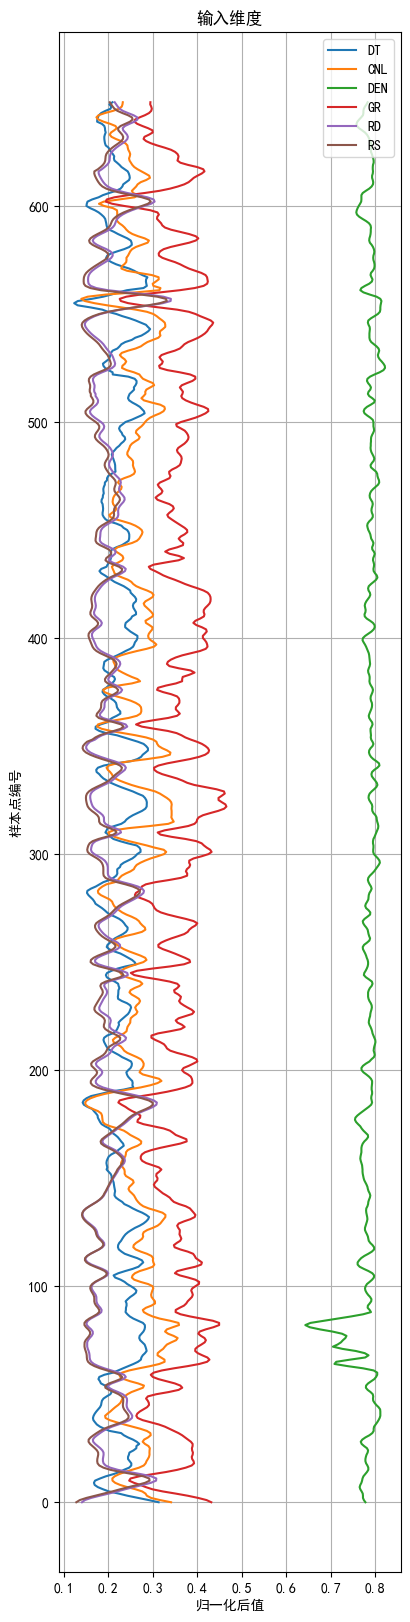

In [60]:
plt.figure(figsize=(15,20))

plt.subplot(131)
plt.title("输入维度")
sample_index = np.arange(len(AB_G))
for i in range(len(input_vectors)):
    plt.plot(AB_G[input_vectors[i]],sample_index, label=input_vectors[i])
plt.xlabel("归一化后值")
plt.ylabel("样本点编号")
plt.legend(loc='upper right')
plt.grid(True)

if model_stage == "train":
    plt.subplot(132)
    plt.title("目标维度")
    plt.plot(AB_Y_G,sample_index, color = "green", label = element_name)
    plt.xlabel("归一化后值")
    plt.ylabel("样本点编号")
    plt.legend(loc='upper right')
    plt.grid(True)
    
    plt.subplot(133)
    plt.title("计算的目标维度")
    plt.plot(AB_Y_calc_G,sample_index,color = "blue", label = element_name + "_clac")
    plt.xlabel("归一化后值")
    plt.ylabel("样本点编号")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.savefig(model_training_img_file_saving_path + model_training_img_name +"_" + element_name +  '_'+ str(n_layers) + "_layers_" +  "_lr_" + str(
            learning_rate) + "h_dim" + str(hidden_dim) + "_epoch_" + str(EPOCHS)+ '_tendency.png', dpi=96,  bbox_inches='tight')

if model_stage == "test":
    plt.savefig(model_testing_img_file_saving_path + model_testing_image_name +"_" + element_name  + '_'+ str(n_layers) + "_layers_" +  "_lr_" + str(
            learning_rate) + "h_dim" + str(hidden_dim) + "_epoch_" + str(EPOCHS)+ '_tendency.png', dpi=96,  bbox_inches='tight')
plt.show()

In [61]:
element_flag = element.index(element_name)
if model_stage == "train":
    plt.figure(figsize=(8, 8))
    plt.title("relationship")
    plt.scatter(AB_Y_calc_G,AB_Y_G)
    plt.xlabel(reference[element_flag])
    plt.ylabel(element[element_flag])
    plt.xlim(-0.05,1.05)
    plt.ylim(-0.05,1.05)
    #显示网格线"
    plt.grid(True)
    plt.show()
    # plt.savefig(model_testing_img_file_saving_path + model_testing_image_name + 'ValAll.jpg', dpi=220,  bbox_inches='tight')

#     print("You Input a wrong Target Parameter!")

## Input the independent variables data preparation(输入自变量数据准备)

In [62]:
if model_stage == "train":
    AB_Y = np.array(AB_Y_G)
    AB_Y_calc = np.array(AB_Y_calc_G) 
AB_X = np.array(AB_G)

In [63]:
# sample_weight

### Split the training set and the validation set(训练集验证集划分)

Determine whether serialization is required based on the needs of the model
(根据模型需要判定是否需要序列化)

In [64]:
if (flag == 1) or (flag == 2):
    print("不需要序列化")
    if model_stage == "train":
        # 训练阶段
        dataX = AB_X
        dataY = AB_Y
        dataY_calc = AB_Y_calc
        sss = model_selection.ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
        for train_index, test_index in sss.split(dataX):
        # print("TRAIN:", train_index, "TEST:", test_index)
            train_X, test_X = dataX[train_index], dataX[test_index]
            train_Y, test_Y = dataY[train_index], dataY[test_index]
            train_Y_calc, test_Y_calc = dataY_calc[train_index], dataY_calc[test_index]
            train_weight, test_weight = sample_weight[train_index],sample_weight[test_index]
    else:
        # 测试阶段
        testALL_A_X = AB_X
    if use_depth_log == True:
        DEPTH_AddReslution = depth_log
    else:
        DEPTH_AddReslution = None
else:
    print("序列化")
    if model_stage == "train":
#         if (flag == 1) or (flag == 2):
#             print("不需要序列化")
#             dataX = AB_X
#             dataY = AB_Y
#             dataY_calc = AB_Y_calc
#         else:
        dataX, dataY = sen.build_All_Train_dataset(AB_X, AB_Y, seq_length)
        dataY_calc = sen.build_All_Y_dataset( AB_Y_calc, seq_length)
        weight_matrix = sen.build_All_Y_dataset(sample_weight,seq_length)
            # 使用model_selection.ShuffleSplit抽取样本
        sss = model_selection.ShuffleSplit(n_splits = 10, test_size=0.1, random_state=0)
        for train_index, test_index in sss.split(dataX):
        # print("TRAIN:", train_index, "TEST:", test_index)
            trainX, testX = dataX[train_index], dataX[test_index]
            trainY, testY = dataY[train_index], dataY[test_index]
            train_Y_calc, test_Y_calc = dataY_calc[train_index], dataY_calc[test_index]
            train_weight, test_weight = weight_matrix[train_index],weight_matrix[test_index]
            
    else:
        # 测试阶段
        testALL_A_X = sen.build_All_A_dataset(AB_X, seq_length)
    if use_depth_log == True:
        DEPTH_AddReslution = sen.build_addReslution_DEPTH(depth_log, seq_length)
    else:
        DEPTH_AddReslution = None

序列化


### Confirm the input dimension(确认输入维度)

In [65]:
if (flag == 1) or (flag == 2):
    if model_stage == "train":
        print("input_vectors.length:",len(input_vectors))
        print("train_X.shape:", train_X.shape,"test_X.shape:", test_X.shape)
        print("train_Y.shape:", train_Y.shape,"test_Y.shape:", test_Y.shape)
        print("train_Y_calc.shape:", train_Y_calc.shape,"test_Y_calc.shape:", test_Y_calc.shape)
        print("train_weight.shape:", train_weight.shape,"test_weight.shape:", test_weight.shape)
    else:
        print("testALL_A_X.shape:", testALL_A_X.shape,"\n","input_vectors.length:",len(input_vectors))
else:
    if model_stage == "train":
        print("input_vectors.length:",len(input_vectors))
        print("trainX.shape:", trainX.shape,"testX.shape:", testX.shape) 
        print("trainY.shape:", trainY.shape,"testY.shape:", testY.shape)
        print("train_Y_calc.shape:", train_Y_calc.shape,"test_Y_calc.shape:", test_Y_calc.shape)
        print("train_weight.shape:", train_weight.shape,"test_weight.shape:", test_weight.shape)
    else:
        print("testALL_A_X.shape:", testALL_A_X.shape,"\n","input_vectors.length:",len(input_vectors))

testALL_A_X.shape: (641, 8, 6) 
 input_vectors.length: 6


In [66]:
# train_weight

# Network instantiation(网络实例化)

## Build a network or load a model(构建网络或载入模型)

In [67]:
def model_type_select(model_type):
    if model_type == 'DNN':
        return sms.dnn_model(model_para)
    elif model_type == 'DNN_2':
        return sms.dnn_model_2(model_para)
    elif model_type == 'RBF':
        n_layers = 3
        # return sms.rbf_model(train_X,model_para)
        return sms.rbf_model(model_para)
    elif model_type == 'LSTM':
        return sms.lstm_cell_model(model_para)
    elif model_type == 'GRU':
        return sms.gru_cell_model(model_para)
    elif model_type == 'GRU2':
        return sms.gru_block_cell_2(model_para)
    # elif model_type == 'NAS':
    #     return nas_cell()
    elif model_type == 'BLSTM':
        return sms.bi_lstm_cell_model(model_para)
    elif model_type == 'BGRU':
        return sms.bi_gru_cell_model(model_para)
    elif model_type == 'BiGRU-Atten':
        return sms.bigru_atten_model(model_para)
    elif model_type == 'BiGRU-Atten2':
        return sms.bigru_atten_model_2(model_para)
    elif model_type == 'WaveNet':
        return sms.wavenet_model(model_para)
    elif model_type == 'MyWaveNet':
        return sms.wavenet_model2(model_para)
    elif model_type == 'Double_Expert_Net':
        return sms.double_experts_Net_model(model_para)
    elif model_type == 'MyUNet':
        return sms.my_unet(model_para)
    elif model_type == 'Capsule':
        return sms.bilstm_capsule_model(model_para)
    elif model_type == 'BLSTM-Atten':
        return sms.bilstm_atten_model(model_para)
    elif model_type == 'BiLSTM-Atten2':
        return sms.bilstm_atten_model_2(model_para)
    elif model_type == 'BiLSTM-Atten3':
        return sms.bilstm_atten_model_3(model_para)
    elif model_type == 'BiLSTM-Atten4':
        return sms.bilstm_atten_model_4(model_para)
    elif model_type == 'BiLSTM-Atten5':
        return sms.bilstm_atten_model_5(model_para)
    elif model_type == 'BiLSTM-Atten6':
        return sms.bilstm_atten_model_6(model_para)
    elif model_type == 'CNN_Atten':
        return sms.wavenet_atten_model(model_para)
    else:
        return sms.bi_lstm_cell_model(model_para)

In [68]:
if model_stage == "test":
    print(pred_model_file)

curve_reconstract_model/泉头组_sampleweight_double_expert_net_train/古页1_for_松页油1_泉头组_double_expert_net_DTXX_3_layers__lr_0.005h_dim12_epoch_30.h5


In [69]:
# from attention_layer import AttentionLayer
# from tensorflow.keras import backend as Kbackend
# from tensorflow.keras.layers import Activation,Lambda, Multiply, Add, Concatenate
# import tensorflow as tf
# # import keras
# from tensorflow.keras.layers import Layer
# from tensorflow.keras import initializers
# from tensorflow.keras.initializers import RandomUniform, Initializer, Constant
# from tensorflow import keras
# from tensorflow.keras import layers
# # from keras_self_attention import SeqSelfAttention
# import numpy as np
# from sklearn.cluster import KMeans
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
# from tensorflow.keras.layers import GlobalAveragePooling1D, MaxPool1D, GlobalMaxPool1D, UpSampling1D
# from tensorflow.keras.layers import Concatenate,concatenate

# def wavenet_atten_model(model_parameter):
#     # convolutional operation parameters
#     n_filters = model_parameter.hidden_dim # 32 
#     filter_width = 2
#     # dilation_rates = [2**i for i in range(8)] * 2   # 
#     # dilation_rates = [2**i for i in range(model_parameter.seq_length)] * 2
#     dilation_rates = [2**i for i in range(model_parameter.seq_length)] * 2 
    
#     # define an input history series and pass it through a stack of dilated causal convolution blocks. 
#     history_seq = Input(shape=(model_parameter.seq_length, model_parameter.data_dim))
#     x = history_seq
    
#     # 增加正则化层-2020-03-20
#     x = tf.keras.layers.BatchNormalization()(x)
    
#     skips = []
#     for dilation_rate in dilation_rates:
        
#         # preprocessing - equivalent to time-distributed dense
#         # x = Conv1D(16, 1, padding='same')(x) data_dim
#         # x = Conv1D(model_parameter.seq_length * 2, 1, padding='same')(x)
#         x = Conv1D(model_parameter.data_dim * 4, 1, padding='same')(x)
 
        
#         # filter convolution
#         x_f = Conv1D(filters=n_filters,
#                     kernel_size=filter_width, 
#                     padding='causal',
#                     dilation_rate=dilation_rate)(x)
        
#         # gating convolution
#         x_g = Conv1D(filters=n_filters,
#                     kernel_size=filter_width, 
#                     padding='causal',
#                     dilation_rate=dilation_rate)(x)
        
#         # multiply filter and gating branches
#         # z = Multiply()([Activation('tanh')(x_f),
#         #                Activation('sigmoid')(x_g)])
#         z = Multiply()([Activation('tanh')(x_f),
#                         Activation('relu')(x_g)])
        
#         # postprocessing - equivalent to time-distributed dense
#         # z = Conv1D(16, 1, padding='same')(z)
#         # z = Conv1D(model_parameter.seq_length * 2, 1, padding='same')(z)
#         z = Conv1D(model_parameter.data_dim * 4, 1, padding='same')(z)
        
        
#         # residual connection
#         x = Add()([x, z])

# #         repeated_word_attention = tf.keras.layers.RepeatVector(model_parameter.hidden_dim * 4)(attention_layer)
# #         repeated_word_attention = tf.keras.layers.Permute([2, 1])(repeated_word_attention)
# #         sentence_representation = tf.keras.layers.Multiply()([z, repeated_word_attention])
    
# #         # sentence_representation = tf.keras.layers.Lambda(lambda x: Kbackend.sum(x, axis=1))(sentence_representation)
# #         # skips.append(sentence_representation) 
# #         z = tf.keras.layers.Lambda(lambda x: Kbackend.sum(x, axis=1))(sentence_representation)
#         # collect skip connections
#         skips.append(z)

#     # add all skip connection outputs 
# #     out = Activation('relu')(Concatenate()(skips))
# #     out = Activation('relu')(Add()(skips))
#     out = Add()(skips)

#     # final time-distributed dense layers 
#     # out = Conv1D(128, 1, padding='same')(out)
#     out = Conv1D(model_parameter.data_dim * 2, 1, padding='same')(out)
#     # out = Activation('relu')(out)
#     out = Dropout(model_parameter.dropout_rate)(out)
#     out = Conv1D(1, 1, padding='same')(out)
#     out = GlobalAveragePooling1D()(out)
# #     out = AttentionLayer()(out)
    
#     pred_seq_train = layers.Dense(model_parameter.output_dim)(out)
#     # pred_seq_train = Dropout(model_parameter.dropout_rate)(pred_seq_train)

#     # extract the last 60 time steps as the training target
#     # def slice(x, seq_length):
#     #     return x[:,-seq_length:,:]

#     # pred_seq_train = Lambda(slice, arguments={'seq_length':model_parameter.seq_length})(out)

#     model = Model(history_seq, pred_seq_train)
    
#     optimizer = tf.keras.optimizers.Adam(model_parameter.learning_rate)
#     # optimizer = tf.keras.optimizers.RMSprop(model_parameter.learning_rate)
#     # loss = 'mse', 'mean_squared_error', 'huber_loss'
#     my_loss = 'mse'
#     model.compile(optimizer=optimizer,
#                   loss = my_loss,
#                   metrics=['mae', 'mse'])
#     return model

## Model visualization(模型可视化)

In [70]:
model = tf.keras.Model()
if model_stage == "train":
    model =  model_type_select(model_type)
#     model = wavenet_atten_model(model_para)
    # model = sms.bi_lstm_cell_model(model_para)
    # model = bilstm_capsule_model(model_para)
else:
    with open(pred_model_json, "r") as json_file_1:
        json_config_1 = json_file_1.read()
        # 此处加载模型无需判断 
        model = tf.keras.models.model_from_json(json_config_1,custom_objects={'RBFLayer': sms.RBFLayer,
                                                                              'AttentionLayer':sms.AttentionLayer,
                                                                              'GlorotUniform':tf.keras.initializers.GlorotUniform
                                                                              })
        model.load_weights(pred_model_file)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8, 6)]       0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 8, 6)        24          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 8, 6)        24          ['batch_normalization[0][0]']    
 rmalization)                                                                                     
                                                                                            

In [71]:
# 定义结果打印函数
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 10 == 0:
            print('已经训练完'+ epoch +'Epoch')
            print('.', end='')

In [72]:
#if  pg.find_graphviz() is not None:
if model_stage == "train":
    model_image_path = model_path
else:
    model_image_path = csv_file_saving_path
if plot_modelnet == True:
    tf.keras.utils.plot_model(model,to_file= model_image_path + element_name + '_' + model_type + '_net.png',
               show_shapes=True,
               show_layer_names=True,
               rankdir='TB',
               expand_nested=False,
               dpi=96)

## The log storage content is set(日志保存内容设定)

In [73]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

if not os.path.exists(log_path):
    # 针对第一次训练
    os.makedirs(log_path)
my_log_dir = os.path.join(log_path,model_type.lower())
print("my_log_dir:",my_log_dir)
if not os.path.exists(my_log_dir):
    os.mkdir(my_log_dir)

str_name = model_name.split(".h5")[0]
# log_name = str_name + "-{}".format(int(time.time()))
log_name = "{}".format(int(time.time()))
curve_reconstract_logs_child_dir = os.path.join(my_log_dir,log_name)
print("curve_reconstract_logs_child_dir:",curve_reconstract_logs_child_dir)
if not os.path.exists(curve_reconstract_logs_child_dir):
    os.mkdir(curve_reconstract_logs_child_dir)

my_log_dir: curve_reconstract_logs/double_expert_net
curve_reconstract_logs_child_dir: curve_reconstract_logs/double_expert_net\1682067674


# Model training and testing(模型训练与测试)

## Model training and validation（模型训练与验证）

fit函数解析 
```
fit( x, y, batch_size=32, epochs=10, verbose=1, callbacks=None,
validation_split=0.0, validation_data=None, shuffle=True, 
class_weight=None, sample_weight=None, initial_epoch=0)
```

* x：输入数据。如果模型只有一个输入，那么x的类型是numpy array，如果模型有多个输入，那么x的类型应当为list，list的元素是对应于各个输入的numpy array  
* y：标签，numpy array  
* batch_size：整数，指定进行梯度下降时每个batch包含的样本数。训练时一个batch的样本会被计算一次梯度下降，使目标函数优化一步。  
* epochs：整数，训练终止时的epoch值，训练将在达到该epoch值时停止，当没有设置initial_epoch时，它就是训练的总轮数，否则训练的总轮数为epochs - inital_epoch  
* verbose：日志显示，0为不在标准输出流输出日志信息，1为输出进度条记录，2为每个epoch输出一行记录  
* callbacks：list，其中的元素是keras.callbacks.Callback的对象。这个list中的回调函数将会在训练过程中的适当时机被调用，参考回调函数  
* validation_split：0~1之间的浮点数，用来指定训练集的一定比例数据作为验证集。验证集将不参与训练，并在每个epoch结束后测试的模型的指标，如损失函数、精确度等。注意，validation_split的划分在shuffle之前，因此如果你的数据本身是有序的，需要先手工打乱再指定validation_split，否则可能会出现验证集样本不均匀。  
* validation_data：形式为（X，y）的tuple，是指定的验证集。此参数将覆盖validation_spilt。
* shuffle：布尔值或字符串，一般为布尔值，表示是否在训练过程中随机打乱输入样本的顺序。若为字符串“batch”，则是用来处理HDF5数据的特殊情况，它将在batch内部将数据打乱。  
* class_weight：字典，将不同的类别映射为不同的权值，该参数用来在训练过程中调整损失函数（只能用于训练）  
* sample_weight：权值的numpy array，用于在训练时调整损失函数（仅用于训练）。可以传递一个1D的与样本等长的向量用于对样本进行1对1的加权，或者在面对时序数据时，传递一个的形式为（samples，sequence_length）的矩阵来为每个时间步上的样本赋不同的权。这种情况下请确定在编译模型时添加了sample_weight_mode=’temporal’。Timestep-wise sample weighting (use of sample_weight_mode="temporal") is restricted to outputs that are at least 3D, i.e. that have a time dimension.
* initial_epoch: 从该参数指定的epoch开始训练，在继续之前的训练时有用。  

In [74]:
def scheduler(epoch):
# 每隔10个epoch，学习率减小为原来的1/10
    if epoch % 10 == 0 and epoch != 0:
        lr = Kbackend.get_value(model.optimizer.lr)
        Kbackend.set_value(model.optimizer.lr, lr * 0.1)
        print("lr changed to {}".format(lr * 0.1))
    return Kbackend.get_value(model.optimizer.lr)

# keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
if learning_rate_deacy_policy == 1:
    reduce_lr = [
        LearningRateScheduler(scheduler),
         # tf.keras.callbacks.ModelCheckpoint(model_file,
          #                      save_best_only=True)
    ]
elif learning_rate_deacy_policy == 2:
    reduce_lr = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience = 5,verbose=2, mode='auto'),
    ]
        
else:
     # reduce_lr =  PrintDot()
    reduce_lr = [
        PrintDot(),
    ]
    
# 原文链接：https://blog.csdn.net/zzc15806/article/details/79711114

In [75]:
my_callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir =  curve_reconstract_logs_child_dir),
    tf.keras.callbacks.ModelCheckpoint(model_file,save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=5,mode='auto', min_delta=1e-9),
]


# tensorboard = TensorBoard(log_dir = my_log_dir + '\{}'.format(log_name))

In [76]:
if model_stage == "train":
    if (flag == 1) or (flag == 2):
        print("flag:",flag)
        My_X = train_X
        My_Y = train_Y
        My_Test_X = test_X
        My_Test_Y = test_Y
        My_Weight =  train_weight #
    else:
        print("flag:",flag)
        My_X = trainX # trainX, dataX
        My_Y = trainY # trainY， dataY 
        My_Test_X = testX
        My_Test_Y = testY
        My_Weight = train_weight  # train_weight ,weight_matrix
        # history = model.fit(train_X, train_Y, batch_size=BATCH_SIZE,epochs=EPOCHS,
        #                validation_split = 0.1, verbose=1,callbacks=[PrintDot()])
    #     dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
    #     train_dataset  = dataset.shuffle(len(train_Y)).batch(1)
    #     t_dataset = tf.data.Dataset.from_tensor_slices((test_X,test_Y))
    #     val_dataset  = dataset.shuffle(len(test_Y)).batch(1)
    #     history = model.fit(train_dataset, epochs=EPOCHS,
    #                      validation_data = val_dataset, verbose=1,callbacks=[PrintDot()])

    if batch_size_strategy == True:
        if save_logs == False:
            history = model.fit(My_X, My_Y, batch_size = BATCH_SIZE,epochs=EPOCHS,validation_data = (My_Test_X,My_Test_Y),sample_weight = My_Weight, verbose=1,callbacks=reduce_lr)
        else:
            history = model.fit(My_X, My_Y, batch_size = BATCH_SIZE,epochs=EPOCHS,validation_data = (My_Test_X,My_Test_Y),sample_weight = My_Weight, verbose=1,callbacks=my_callbacks)
    else:
        if save_logs == False:
            history = model.fit(My_X, My_Y, epochs = EPOCHS,validation_data = (My_Test_X,My_Test_Y),sample_weight = My_Weight, verbose=1,callbacks = reduce_lr)
        else:
            history = model.fit(My_X, My_Y, epochs = EPOCHS,validation_data = (My_Test_X,My_Test_Y),sample_weight = My_Weight, verbose=1,callbacks = my_callbacks)
else:
    print("model_stage:", model_stage)

model_stage: test


## Model testing(模型测试)

model.evaluate输入数据(data)和金标准(label),然后将预测结果与金标准相比较,得到两者误差并输出.  
model.predict输入数据(data),输出预测结果  
* 是否需要真实标签(金标准)  
model.evaluate需要,因为需要比较预测结果与真实标签的误差  
model.predict不需要,只是单纯输出预测结果,全程不需要金标准的参与.  

In [77]:
def plot_history(history,model_training_img_file_saving_path,model_training_img_name):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MAE]')
    plt.plot(hist['epoch'], hist['mae'],label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],label = 'Val Error')
    # plt.ylim([0,5])
    plt.legend()
    plt.savefig(model_training_img_file_saving_path + model_training_img_name + '_MAE.png', dpi=96,  bbox_inches='tight')

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [MSE]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    # plt.ylim([0,20])
    plt.legend()
    
    plt.savefig(model_training_img_file_saving_path + model_training_img_name +"_" + element_name + '_'+ str(n_layers) + "_layers_" +  "_lr_" + str(
        learning_rate) + "h_dim" + str(hidden_dim) + "_epoch_" + str(EPOCHS) + '_loss.png', dpi=96,  bbox_inches='tight')
    plt.show()
    

In [78]:
if model_stage == "train":
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    print(hist.tail())
    plot_history(history,model_training_img_file_saving_path,model_training_img_name)
    loss_csv_file_save = os.path.join(csv_file_saving_path ,   model_name + "trainloss.csv")
    hist.to_csv(loss_csv_file_save, mode='w',float_format='%.4f',sep=',',index=None,header=True)

In [79]:
if model_stage == "train":
    plt.figure(figsize=(6,40))
    if (flag == 1) or (flag == 2):
        predictions = model.predict(test_X)
#         np.testing.assert_allclose(predictions, test_Y, atol=1e-6)
        loss, mae, mse = model.evaluate(test_X, test_Y, verbose=2)
        sample_index = np.arange(len(test_Y))
        plt.plot(test_Y,sample_index, label="实测")  
    else:
        predictions = model.predict(testX)
#         np.testing.assert_allclose(predictions, testY, atol=1e-6)
        loss, mae, mse = model.evaluate(testX, testY, verbose=2)
        sample_index = np.arange(len(testY))
        plt.plot(testY,sample_index, label="实测")
    # plt.plot(test_Y_calc,sample_index, label="计算")
    plt.plot(predictions,sample_index, label="预测")
    plt.grid(True)#显示网格线"
    plt.xlabel( element_name)
    plt.ylabel("验证样本编号")
    plt.title(element_name + "在验证集上")
    plt.legend(loc='best')
    plt.savefig(model_training_img_file_saving_path + model_training_img_name +"_" + element_name + '_'+ str(n_layers) + "_layers_" +  "_lr_" + str(
        learning_rate) + "h_dim" + str(hidden_dim) + "_epoch_" + str(EPOCHS)+ '_val.png', dpi=96,  bbox_inches='tight')
    plt.show()
    print("Testing set Mean Abs Error: {:5.5f} ".format(mae))
    print("Testing set Mean Abs Error: {:5.5f} ".format(mse))
# 对于测试阶段目前暂不计算MSE，等反归一化后计算  
# else:
#    A_Y_predict = model.predict(testALL_A_X)

## Linear correlation analysis between the predicted value of the validation set and the true calibration value（验证集预测值与真实标定值线性相关性分析)

In [80]:
if model_stage == "train":
    if (flag == 1) or (flag == 2):
        GT = test_Y
    else:
        GT = testY
    
    rmse = np.sqrt(mean_squared_error(GT, predictions))  
    rmae = np.sqrt(mean_absolute_error(GT, predictions)) 
    ols = sm.OLS(GT, predictions).fit()
    

    print('验证集预测值与真实标定值线性相关性分析')
    print(ols.summary())
    print('Test RMSE: %.3f' % rmse)
    print('Test RMAE: %.3f' % rmae)
    rmse = "{:.9f}".format(rmse)
    rmae = "{:.9f}".format(rmae)

In [81]:
if model_stage == "train":
    summary_result = sm.iolib.summary.Summary.as_text(ols.summary())
    corr_index = summary_result.split("\nModel")[0].split("R-squared (uncentered):")[-1].strip()
    print(corr_index)

In [82]:
if model_stage == "train":
    float(corr_index)

In [83]:
error = []
if model_stage == "train":
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    if (flag == 1) or (flag == 2):
        plt.scatter(test_Y, predictions)
        error = predictions - test_Y
        # rmse = np.sqrt(mean_squared_error(test_Y, predictions))
    else:
        plt.scatter(testY, predictions)
        error = predictions - testY
        # rmse = np.sqrt(mean_squared_error(testY, predictions))
    plt.xlabel('True Values [MPG]')
    plt.ylabel('Predictions [MPG]')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    plt.text(0.1 * plt.xlim()[1],0.9 * plt.ylim()[1], 'RMSE:' + str(rmse),fontdict=font)
    plt.text(0.1 * plt.xlim()[1],0.85 * plt.ylim()[1], 'RMAE:' + str(rmae),fontdict=font)
    plt.text(0.65 * plt.xlim()[1],0.1 * plt.ylim()[1], 'R:' + str(corr_index),fontdict=font)
    _ = plt.plot([-100, 100], [-100, 100])
    # plt.savefig(model_training_img_file_saving_path + model_training_img_name +"_" + element_name + '_'+ str(n_layers) + "_layers_" +  "_lr_" + str(
    #    learning_rate) + "h_dim" + str(hidden_dim) + "_epoch_" + str(EPOCHS)+ '_jiaohui.png', dpi=96,  bbox_inches='tight')
    
    plt.subplot(122)
    plt.hist(error, bins = 25)
    plt.xlabel("Prediction Error [MPG]")
    _ = plt.ylabel("Count")
    
    plt.savefig(model_training_img_file_saving_path + model_training_img_name +"_" + element_name + '_'+ str(n_layers) + "_layers_" +  "_lr_" + str(
        learning_rate) + "h_dim" + str(hidden_dim) + "_epoch_" + str(EPOCHS)+ '_predError_Distribution.png', dpi=96,  bbox_inches='tight')
    plt.show()
    # print('Test RMSE: %.3f' % rmse)

# Model Save(模型保存)

In [84]:
# if model_stage == "train":
#     if paly_music == True:
#         mixer.init()
#         music_path = "music/"
#         file = "MISIA - 星のように.mp3"
#         music_file = os.path.join(music_path,file)
#         mixer.music.load(music_file)
#         mixer.music.play()
#         time.sleep(10)
#         mixer.music.stop()
        # exit()

In [85]:
if model_stage == "train":
    json_config = model.to_json()
    with open(model_json, 'w') as json_file:
        json_file.write(json_config)

    model.save_weights(model_file)
    print("Model Save is Finished!")
else:
    print("Testing...")

Testing...


# Post-processing of the prediction results(对预测结果后处理)

## The part that is predicted to be less than 0 is processed as 0（对预测小于0的部分进行取0处理）

In [86]:
if model_stage == "train":
    # A_Y_predict = predictions
    A_Y_predict = model.predict(dataX)
else:
    A_Y_predict = model.predict(testALL_A_X)
    print(min(A_Y_predict),A_Y_predict.shape)

21/21 [==============================] - 3s 3ms/step
[0.07825512] (641, 1)


In [87]:
A_Y_predict_final_GY = A_Y_predict.copy()
for j in range(0, len(A_Y_predict_final_GY)):
    if A_Y_predict[j] < 0:
        A_Y_predict_final_GY[j] = 0

In [88]:
# 查找element_name的索引
pred_element_index = element.index(element_name)
print("pred_element_index:",pred_element_index)

pred_element_index: 0


In [89]:
e_log_name[pred_element_index]

[100, 300]

## Reverse normalization reduces the prediction curve（根据归一化范围还原对应分辨率的预测曲线）

In [90]:
testALL_Y_predict_final = sen.revivification_scaler(A_Y_predict_final_GY,e_log_name,pred_element_index)
if model_stage == "train":
    true_Y = sen.revivification_scaler(dataY,e_log_name,pred_element_index)
    Y_clac = sen.revivification_scaler(dataY_calc,e_log_name,pred_element_index)

In [91]:
if model_stage == "train":
    print(A_Y_predict_final_GY.shape,"testALL_Y_predict_final.shape:",testALL_Y_predict_final.shape,dataY_calc.shape)

In [92]:
# testALL_Y_predict_final

C:\Users\xbs\AppData\Local\Temp\ipykernel_11576\3977957438.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


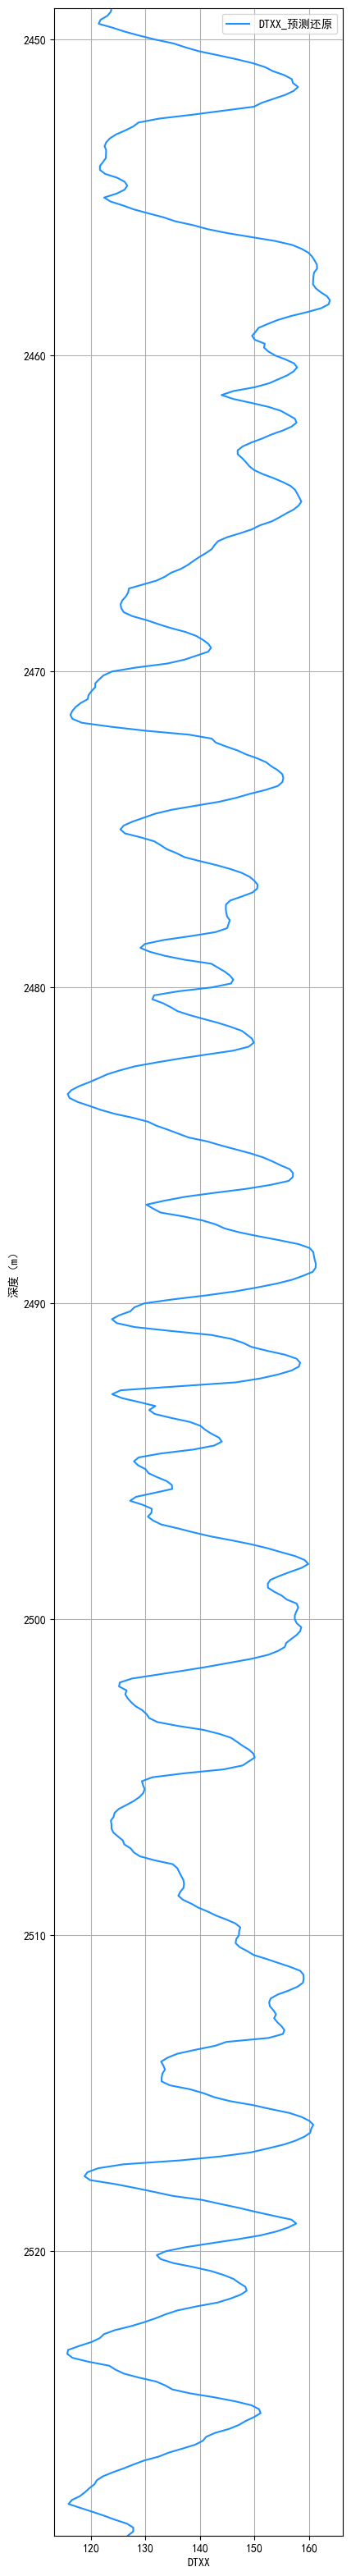

In [93]:
plt.figure(figsize=(10,40))
plt.title(element_name + "预测曲线在训练验证集上")
e_max = max(testALL_Y_predict_final) * 1.2
e_min = min(testALL_Y_predict_final) * 0.8
plt.xlim(e_min,e_max)
if use_depth_log == True:
    plt.subplot(121)
    plt.ylim(DEPTH_AddReslution[-1][0],DEPTH_AddReslution[0][0])
    plt.plot(testALL_Y_predict_final,DEPTH_AddReslution,color="dodgerblue", label= element_name + "_预测还原")
    if model_stage == "train":
        plt.plot(true_Y,DEPTH_AddReslution,color="dodgerblue", label="实测" + element_name)
        plt.subplot(122)
        plt.plot(testALL_Y_predict_final,DEPTH_AddReslution,color="green", label= element_name + "_预测还原")
        plt.plot(Y_clac,DEPTH_AddReslution,color="orange", label="计算" + element_name)
    plt.ylabel("深度（m）")
    plt.xlabel(element_name)
    plt.legend(loc='best')
    plt.grid(True)
else:
    plt.subplot(121)
    all_sample_index = np.arange(len(testALL_Y_predict_final))
    plt.plot(testALL_Y_predict_final,all_sample_index,color="green", label= element_name + "_预测还原")
    plt.legend(loc='best')
    plt.grid(True)
    if model_stage == "train":
        plt.plot(true_Y,all_sample_index,color="dodgerblue", label="实测" + element_name)
        plt.legend(loc='best')
        plt.subplot(122)
        plt.plot(testALL_Y_predict_final,all_sample_index,color="green", label= element_name + "_预测还原")
        plt.plot(Y_clac,all_sample_index,color="orange", label="计算" + element_name)
    plt.ylabel("样本编号")
    plt.xlabel(element_name) 
plt.legend(loc='best')
plt.grid(True)
if model_stage == "train":
    pred_image_save_path = model_training_img_file_saving_path 
    pred_image_name = model_training_img_name
else:
    pred_image_save_path = model_testing_img_file_saving_path 
    pred_image_name = model_testing_image_name + str(begin_depth) + "-"+ str(end_depth) + "m" 
plt.legend(loc='best')
plt.grid(True)
plt.savefig(pred_image_save_path + pred_image_name + '_PredictionAll.png', dpi=96,  bbox_inches='tight')
plt.show()

# The validation operation of the training phase ends with this program（训练阶段的验证操作到此程序结束）

In [94]:
testdata_Y_predict_final = testALL_Y_predict_final

# Total Evaluation Module（总评价模块）

In [95]:
add_flag = 0
if model_stage == "train":
    # 训练阶段
    High_R_ALL = inputY.loc[:, [element_name]]
    High_R = np.array(High_R_ALL)
    High_R.shape = (len(High_R),)
    print("真实标定值为训练数据标签！！！")
    add_flag = 1
    print(add_flag)
else:
    if use_high_R_data == True:
    # 测试阶段
        High_R_ALL = pd.read_csv(HighRDataPath,engine='python',encoding='GBK')
        High_R = High_R_ALL.loc[:, [element_name]]
        High_R = np.array(High_R)
        High_R.shape = (len(High_R),)
        add_flag = 2
        print(add_flag)
    else:
        print("无真实标定值！！！")
        add_flag = 3
        print(add_flag)

2


## Draw line and scatter charts（绘制折线图和散点图）

绘制折线图，预测结果与真实标定趋势对比

In [96]:
if model_stage == "train" and use_depth_log == True:
    plt.figure(figsize=(6, 80))
    plt.title("TrainALL_Y_predict_final_element_log_revivification")
# 说明曲线长度没有矫正过程，预测曲线为testALL_Y_predict_final == testdata_Y_predict_final
    if (flag == 0) or (flag == 1) or (flag == 2):
        High_R_Label = High_R.copy()
        print("2")
        plt.plot(testdata_Y_predict_final,DEPTH_AddReslution,color="red", label="predict_final")
        plt.plot(High_R_Label,DEPTH_AddReslution,color="black", label="GroundTruth")
    else:
        print("3")
        High_R_Label = sen.build_HighReslution_Label(High_R, seq_length)
        plt.plot(testdata_Y_predict_final,DEPTH_AddReslution,color="red", label="predict_final")
        plt.plot(High_R_Label,DEPTH_AddReslution,color="black", label="GroundTruth") 
           
    plt.xlabel(element_name)
    plt.ylabel("DEPTH(m)")
    plt.legend(loc='upper left')
    plt.savefig(model_training_img_file_saving_path + model_training_img_name +"_" + element_name + '_'+ str(n_layers) + "_layers_" +  "_lr_" + str(
        learning_rate) + "h_dim" + str(hidden_dim) + "_epoch_" + str(EPOCHS)+ '_constract_Real.png', dpi=96,  bbox_inches='tight')
    plt.show()
        

In [97]:
use_depth_log

True

In [98]:
if (model_stage == "train" and use_depth_log == False) or (model_stage == "test" and use_high_R_data == True):
    if (flag == 0) or (flag == 1):
        High_R_Label = High_R.copy()
    else:
        High_R_Label = sen.build_HighReslution_Label(High_R, seq_length)
    

In [99]:
# plot_data1 = pd.DataFrame(testdata_Y_predict_final,columns=["预测" + element_name])
# plot_data2 = pd.DataFrame(Y_clac,columns=["计算" + element_name])
# plot_data = pd.concat([plot_data1,plot_data2],axis=1)
# plot_data
testdata_Y_predict_final.shape = (len(testdata_Y_predict_final),)
testdata_Y_predict_final.shape

(641,)

In [100]:
if use_high_R_data == True:
     print(High_R_Label.shape)

(641,)


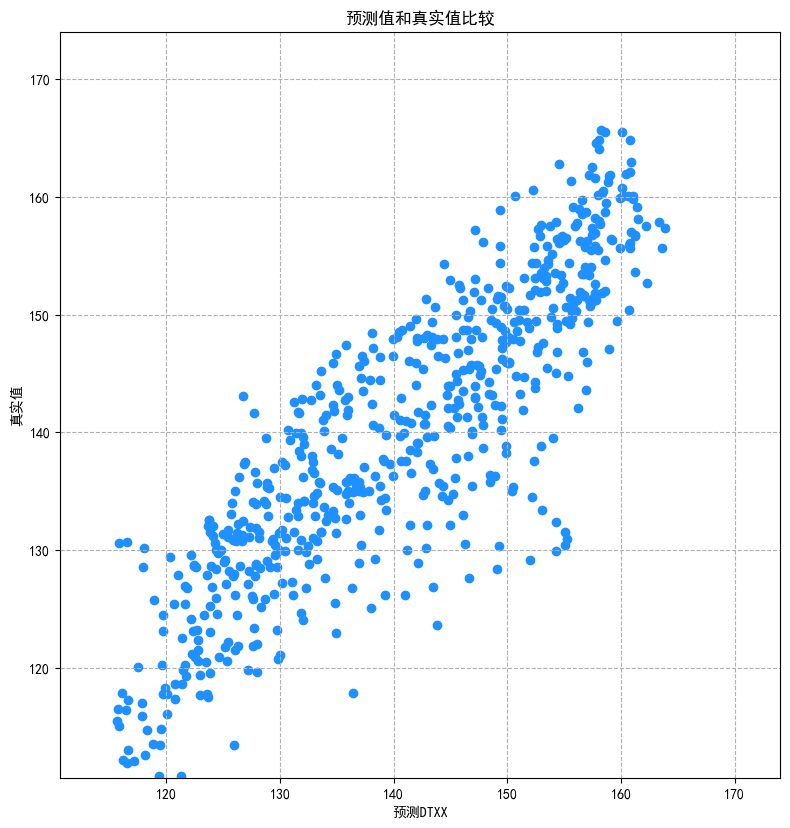

In [101]:
# 绘制散点图
if model_stage == "train" or ((model_stage == "test") and (add_flag == 2)):
    value_max = max(High_R_Label) * 1.05
    value_min = -0.2 + min(High_R_Label) 
    # 说明没有低分辨率曲线，那么就是训练阶段或是有高分辨率的
    plt.figure(figsize=(8, 24))
    plt.subplot(311)
    plt.title("预测值和真实值比较")
    plt.scatter(testdata_Y_predict_final,High_R_Label,color="dodgerblue")
    plt.grid(linestyle = '--')
    plt.xlabel("预测" + element_name)
    plt.ylabel("真实值")
    if model_stage == "train":
        plt.subplot(312)
        plt.title("预测值和计算值比较")
        plt.scatter(testdata_Y_predict_final,Y_clac,color="orange")
        plt.grid(linestyle = '--')
        plt.xlabel("预测" + element_name)
        plt.ylabel("计算" + element_name)
        plt.subplot(313)
        plt.title("预测值和计算值比较")
        plt.scatter(true_Y,Y_clac,color="green")
        plt.grid(linestyle = '--')
        plt.xlabel("真实" + element_name)
        plt.ylabel("计算" + element_name)
    plt.xlim(value_min,value_max)
    plt.ylim(value_min,value_max)
    plt.tight_layout()
    if model_stage == "train":    
        plt.savefig(model_training_img_file_saving_path + model_training_img_name +"_" + element_name + '_'+ str(n_layers) + "_layers_" +  "_lr_" + str(
            learning_rate) + "h_dim" + str(hidden_dim) + "_epoch_" + str(EPOCHS)+ '_constract_scatterMap.png', dpi=96,  bbox_inches='tight')
    else:
        plt.savefig(model_testing_img_file_saving_path + model_testing_image_name + '_constract_scatterMap.png', dpi=96,  bbox_inches='tight')
    plt.show()

3


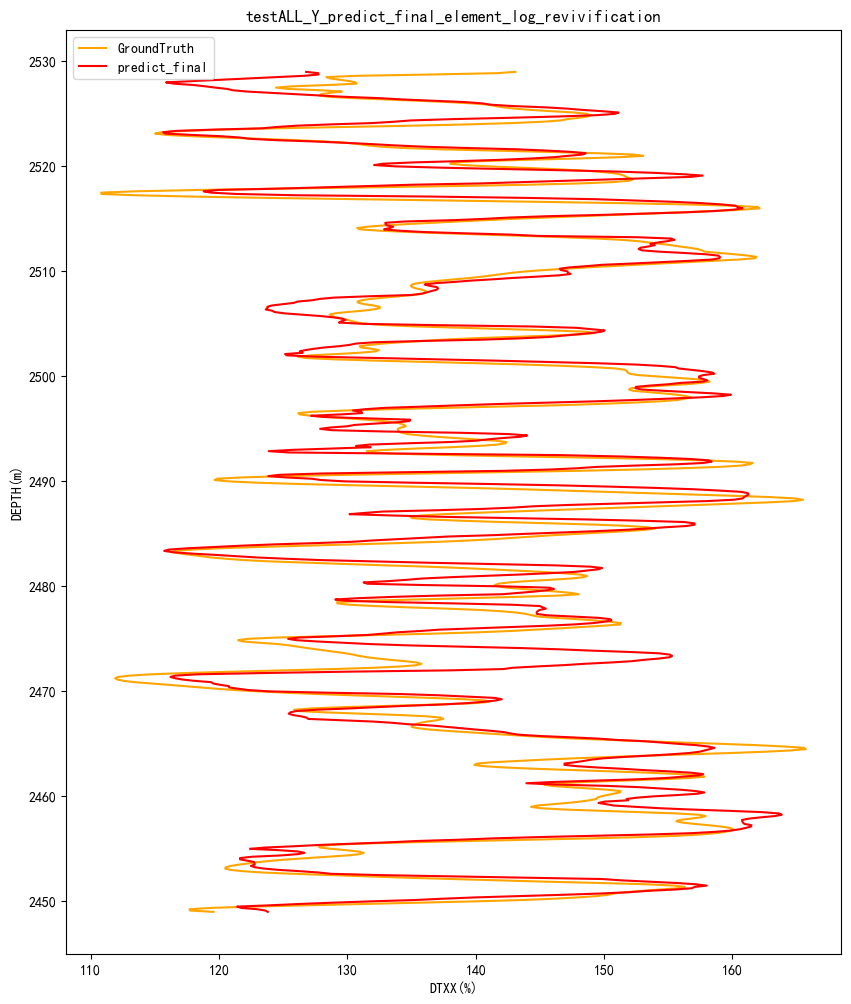

In [102]:
if model_stage == "test" and use_depth_log == True:
    
    plt.figure(figsize=(10, 12))
    plt.title("testALL_Y_predict_final_element_log_revivification")
    # 说明曲线长度没有矫正过程，预测曲线为testALL_Y_predict_final == testdata_Y_predict_final
    if (flag == 0) or (flag == 1):
        print("2")
        if add_flag == 2:
            High_R_Label = High_R
        plt.plot(testdata_Y_predict_final,DEPTH_AddReslution,color="red", label="predict_final")
        plt.plot(High_R_Label,DEPTH_AddReslution,color="orange", label="GroundTruth") 
    else:
        print("3")
        if add_flag == 2:
            High_R_Label = High_R
            High_R_Label = sen.build_HighReslution_Label(High_R, seq_length)
            plt.plot(High_R_Label,DEPTH_AddReslution,color="orange", label="GroundTruth")
        plt.plot(testdata_Y_predict_final,DEPTH_AddReslution,color="red", label="predict_final")
             
            
    plt.xlabel(element_name + "(%)")
    plt.ylabel("DEPTH(m)")
    plt.legend(loc='upper left')
    plt.show()

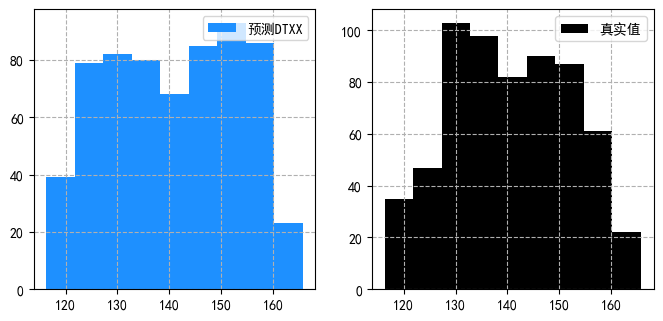

In [103]:
fig_cols = 2
fig_rows = 2
plt.figure(figsize=(4 * fig_cols, 4 * fig_rows))
if (use_high_R_data == True) or (model_stage == "train"):
    a = np.histogram(High_R_Label)[0]
    b = np.histogram(High_R_Label)[1]    
else:    
    a = np.histogram(testdata_Y_predict_final)[0]
    b = np.histogram(testdata_Y_predict_final)[1]

ax1 = plt.subplot2grid((fig_rows, fig_cols), (0, 0))
ax1.hist(testdata_Y_predict_final,color = "dodgerblue", label = "预测" + element_name, bins = b[1:len(b)] )
ax1.legend(loc="upper right")
ax1.grid(linestyle = '--')
    
    
if model_stage == "train":
    ax2 = plt.subplot2grid((fig_rows, fig_cols), (0, 1))
    ax2.hist(High_R_Label,color = "black",label = "真实值",bins = b[1:len(b)])
    ax2.legend(loc="upper right")
    ax2.grid(linestyle = '--') 
elif (model_stage == "test") and (add_flag == 2):
    ax2 = plt.subplot2grid((fig_rows, fig_cols), (0, 1))
    ax2.hist(High_R_Label,color = "black",label = "真实值",bins = b[1:len(b)])
    ax2.legend(loc="upper right")
    ax2.grid(linestyle = '--')
    

plt.legend(loc="upper right")
plt.grid(linestyle = '--')
if model_stage == "train":
    plt.savefig(model_training_img_file_saving_path + model_training_img_name +"_" + element_name + '_'+ str(n_layers) + "_layers_" +  "_lr_" + str(
    learning_rate) + "h_dim" + str(hidden_dim) + "_epoch_" + str(EPOCHS)+ '-hist.png', dpi=96,  bbox_inches='tight')
else:
    plt.savefig(model_testing_img_file_saving_path + model_testing_image_name + '-hist.png', dpi=96,  bbox_inches='tight')
plt.show()

## Linear correlation analysis between predicted and true calibration values(预测值与真实标定值线性相关性分析)

In [104]:
if (model_stage == "train") or ((model_stage == "test") and (add_flag == 2)):
    rmse = np.sqrt(mean_squared_error(High_R_Label, testdata_Y_predict_final))
    rmae = np.sqrt(mean_absolute_error(High_R_Label, testdata_Y_predict_final)) 
    ols0 = sm.OLS(High_R_Label, testdata_Y_predict_final).fit()
    print('预测值与真实标定值线性相关性分析')
    print(ols0.summary())
    print('Test RMSE: %.3f' % rmse)
    print('Test RMAE: %.3f' % rmae)

预测值与真实标定值线性相关性分析
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          3.024e+05
Date:                Fri, 21 Apr 2023   Prob (F-statistic):                        0.00
Time:                        17:01:24   Log-Likelihood:                         -2105.0
No. Observations:                 641   AIC:                                      4212.
Df Residuals:                     640   BIC:                                      4216.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------

In [105]:
# if use_high_R_data == True:
#     if use_low_R_data == True:
#         MAE = testdata_Y_predict_final - High_R_Label
#     else:
#         MAE = testALL_Y_predict_final - High_R_Label

## View the distribution of prediction curves and true calibrations(查看预测曲线和真实标定的分布)

In [106]:
font = {'family':'SimHei',
     'style':'italic',
    'weight':'normal',
      'color':'red',
      'size':16
}

d:\Program Files\Python310\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
d:\Program Files\Python310\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


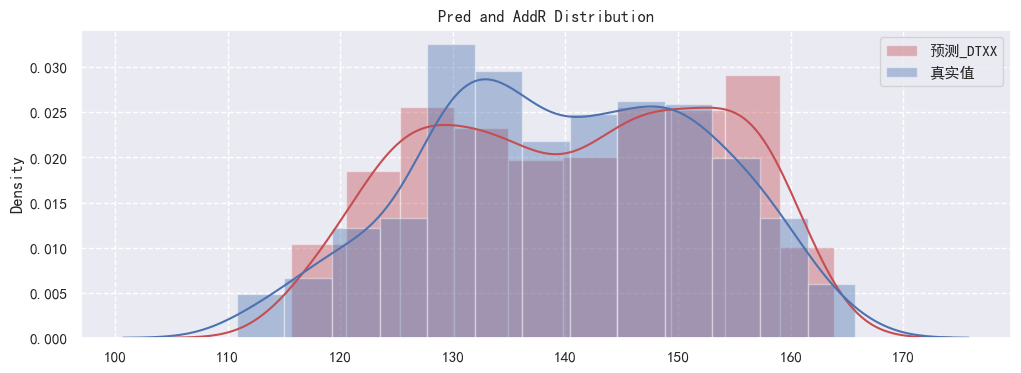

In [107]:
# if use_high_R_data == True:
if (model_stage == "train") or ((model_stage == "test") and (add_flag == 2)):
    sns.set_style('white')
    sns.set(font=font['family'])
        # 图表风格设置
        # 风格选择包括："white", "dark", "whitegrid", "darkgrid", "ticks"
    
    plt.figure(figsize=(12, 4))#绘制画布
    plt.title("Pred and AddR Distribution")  # 添加图表名
    sns.distplot(testdata_Y_predict_final,  kde=True,label = "预测_" + element_name,hist=True,color='r')
    sns.distplot(High_R_Label,  label = "真实值", kde=True,hist=True,color='b')
    plt.legend(loc="upper right")
    plt.grid(linestyle = '--')     # 添加网格线
   

    if model_stage == "train":
        plt.savefig(model_training_img_file_saving_path + model_training_img_name +"_" + element_name + '_'+ str(n_layers) + "_layers_" +  "_lr_" + str(
            learning_rate) + "h_dim" + str(hidden_dim) + "_epoch_" + str(EPOCHS)+ '_add-R_hist.png', dpi=96,  bbox_inches='tight')
    else:
        plt.savefig(model_testing_img_file_saving_path + model_testing_image_name + '_add-R-hist.png', dpi=96,  bbox_inches='tight')

    plt.show()
elif ((model_stage == "test") and (add_flag == 3)):
    
    sns.set_style('white')
        # 图表风格设置
        # 风格选择包括："white", "dark", "whitegrid", "darkgrid", "ticks"

    plt.figure(figsize=(12, 4))#绘制画布
    sns.distplot(testALL_Y_predict_final,  kde=True,label = "预测_" + element_name,hist=False,color='r')
        # sns.distplot(C_element,  label = "C_element", kde=True,hist=False,color='b')
    plt.legend(loc="upper right")
    plt.grid(linestyle = '--')     # 添加网格线
    plt.title("Pred and AddR Distribution")  # 添加图表名
    plt.savefig(model_testing_img_file_saving_path + model_testing_image_name + '_add-R-D.png', dpi=96,  bbox_inches='tight')
    plt.show()
    

# Save the curve results(曲线结果保存)

## Result file header information(结果文件文件头信息)

In [108]:
# filename_A ： 'HP1_orginLog_6D_4075m-4280m_R_0.125.csv'
well_name

'松页油1'

In [109]:
if use_depth_log == True:
    print("begin_depth,end_depth:",begin_depth,end_depth)

begin_depth,end_depth: 2449.0 2529.0


In [110]:
resolution_ratio = 1 / resolution
resolution_ratio

0.125

## View the saved result curves（查看保存的结果曲线）

In [111]:
if use_depth_log == False:
    depth_log = all_sample_index
    DEPTH_AddReslution = all_sample_index

In [112]:
if use_depth_log == True:
    pd_data0 = pd.DataFrame(DEPTH_AddReslution,columns=["DEPTH"])
    result_csv_name = well_name + "_" + layer_name + "_"+ str(begin_depth) + "_"+ str(end_depth) + "m_" + element_name + '_Pred_R_'+ sen.tid_maker() +'.txt'
else:
    pd_data0 = pd.DataFrame(all_sample_index,columns=["sample_index"])
    result_csv_name = well_name + "_" + layer_name + "_" + element_name + '_Pred_R_'+ sen.tid_maker() +'.txt'
pd_data1 = pd.DataFrame(testALL_Y_predict_final,columns=[element_name + "_pred"])
if use_high_R_data:
    pd_data2 = pd.DataFrame(High_R_Label,columns=[element_name + "_High_R"])
    pd_data = pd.concat([pd_data0,pd_data1,pd_data2],axis=1)
else:
    pd_data = pd.concat([pd_data0,pd_data1],axis=1)
pd_data.to_csv(csv_file_saving_path + result_csv_name,mode='w',float_format='%.4f',sep='\t',index=None,header=True)
print("Prediction Algorithm is Finished!!")

Prediction Algorithm is Finished!!


In [113]:
# if paly_music == True:
#     mixer.init()
#     music_path = "music/"
#     file = "MISIA - 星のように.mp3"
#     music_file = os.path.join(music_path,file)
#     mixer.music.load(music_file)
#     mixer.music.play()
#     time.sleep(6)
#     mixer.music.stop()
#         # exit()